# Processing Sequences using RNNs & CNNs

### Import Libraries

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

2023-10-24 13:28:18.886219: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


### Basic RNNs

#### Generate the Dataset

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

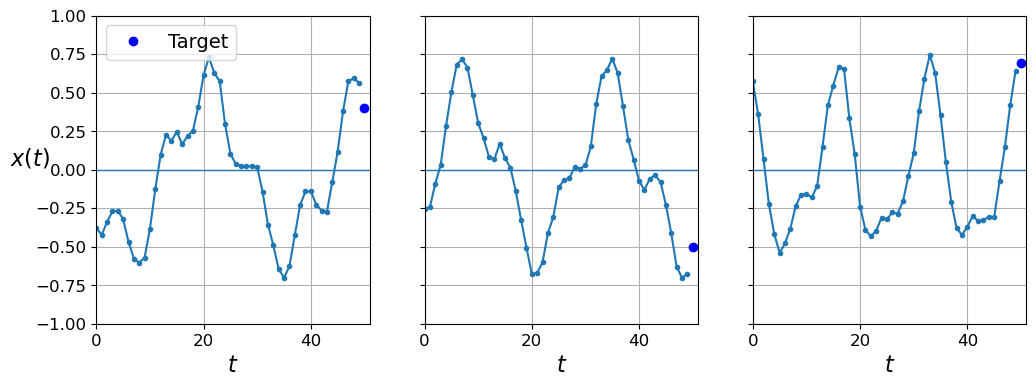

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

### Computing Some Baselines

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

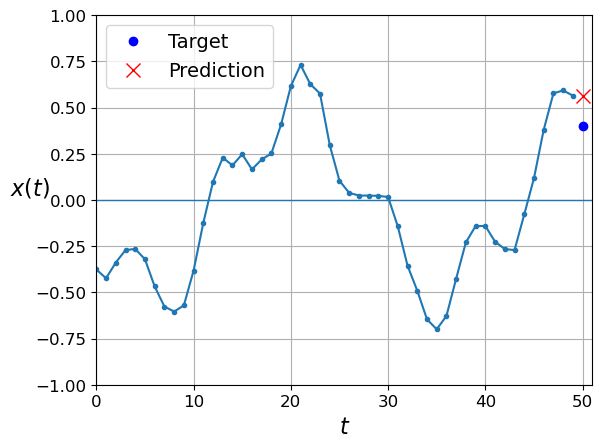

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0937 - val_loss: 0.0412
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0150
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0085
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0066
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0047

In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0037


0.0037047876976430416

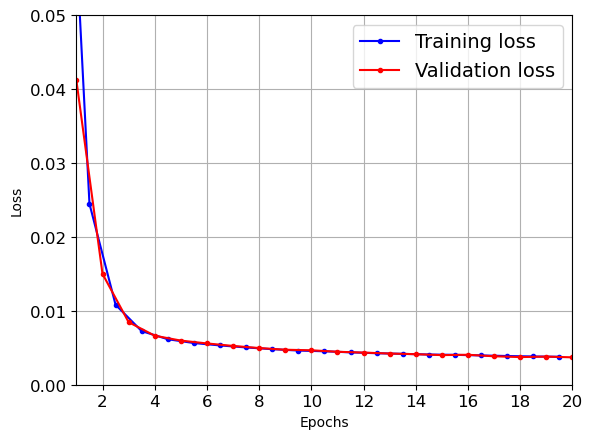

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 1ms/step


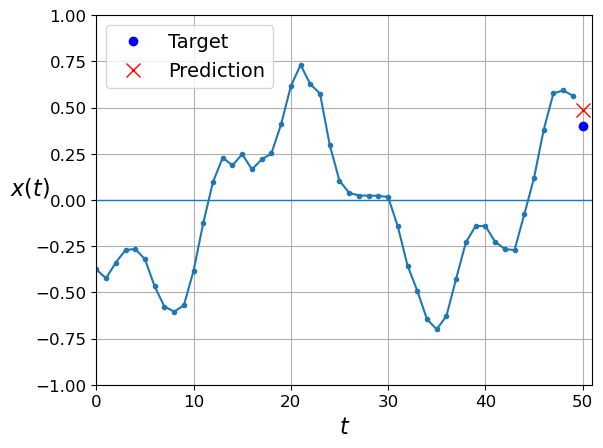

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 12ms/step - loss: 0.0191 - val_loss: 0.0111
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 4/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 7/20
219/219 [==============================] - 3s 11ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 8/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 9/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 10/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0114 - val_loss: 

In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 8ms/step - loss: 0.0109


0.010909891687333584

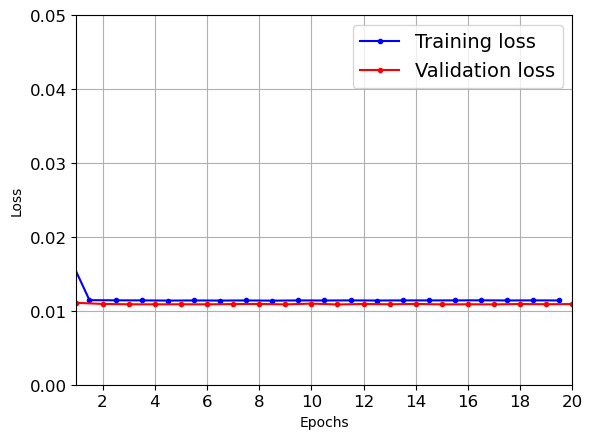

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 12ms/step


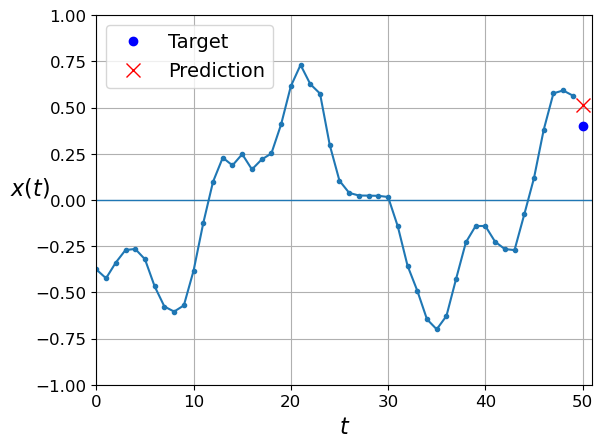

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Deep RNNs

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 10s 33ms/step - loss: 0.0243 - val_loss: 0.0060
Epoch 2/20
219/219 [==============================] - 11s 50ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 3/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 4/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 5/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 6/20
219/219 [==============================] - 9s 43ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 7/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 8/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 10/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0029 - val

In [17]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 17ms/step - loss: 0.0026


0.002629290334880352

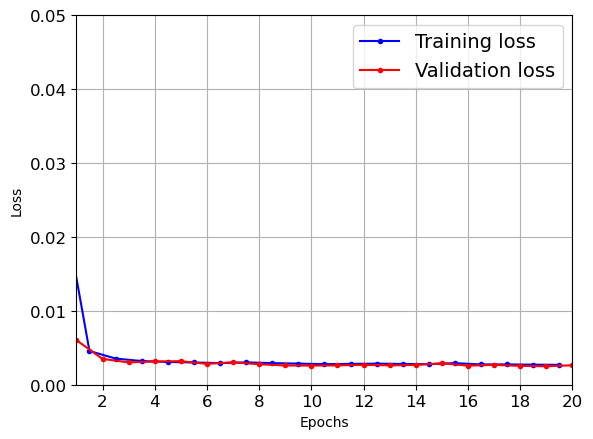

In [18]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 2s 12ms/step


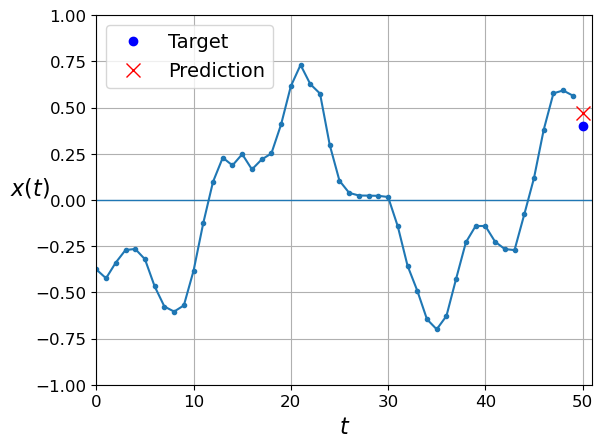

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 9s 27ms/step - loss: 0.0132 - val_loss: 0.0045
Epoch 2/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 3/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 4/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 6/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 7/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 8/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 9/20
219/219 [==============================] - 8s 34ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 10/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0028 - val_lo

In [21]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 8ms/step - loss: 0.0025


0.002528978046029806

63/63 [==============================] - 1s 10ms/step


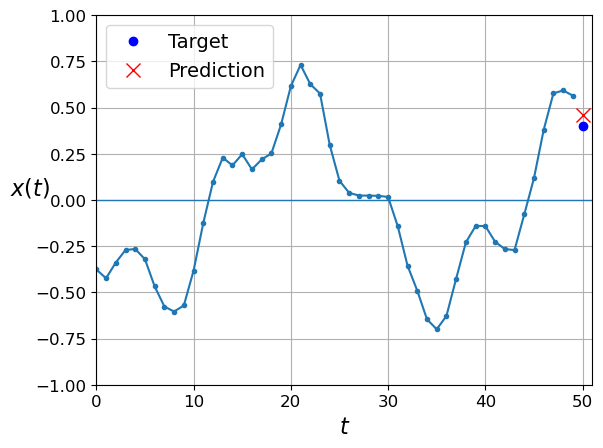

In [22]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Forecasting Several Steps Ahead 

In [23]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 20ms/step


In [24]:
Y_pred.shape

(1, 10, 1)

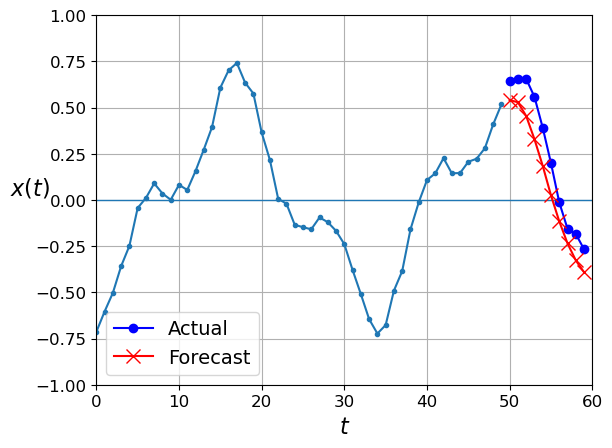

In [25]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [26]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [27]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

63/63 [==============================] - 1s 13ms/step


In [28]:
Y_pred.shape

(2000, 10)

In [29]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.020770423

In [30]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # take the last time step value, and repeat it 10 times
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 5ms/step - loss: 0.1153 - val_loss: 0.0578
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0471 - val_loss: 0.0399
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0358 - val_loss: 0.0326
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0287
Epoch 5/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0276 - val_loss: 0.0264
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0256 - val_loss: 0.0249
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0243 - val_loss: 0.0237
Epoch 8/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0233 - val_loss: 0.0228
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0222
Epoch 10/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0216

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 13s 40ms/step - loss: 0.0715 - val_loss: 0.0310
Epoch 2/20
219/219 [==============================] - 6s 30ms/step - loss: 0.0259 - val_loss: 0.0201
Epoch 3/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0179 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0142 - val_loss: 0.0122
Epoch 5/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0128 - val_loss: 0.0121
Epoch 6/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0124 - val_loss: 0.0107
Epoch 7/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0119 - val_loss: 0.0117
Epoch 8/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0112 - val_loss: 0.0099
Epoch 9/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0108 - val_loss: 0.0118
Epoch 10/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0103 - val_l

In [33]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 [==============================] - 0s 334ms/step


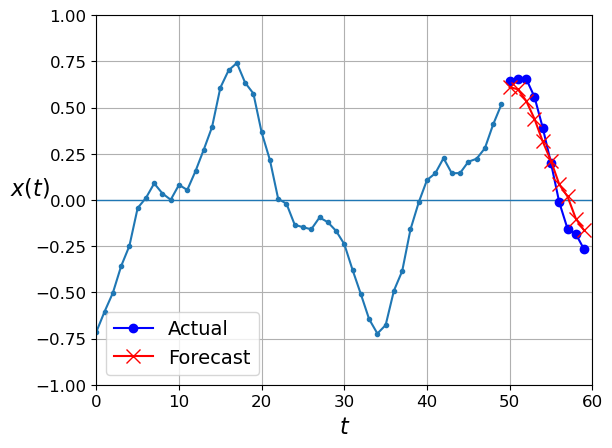

In [34]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [35]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [36]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [37]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 24ms/step - loss: 0.0476 - last_time_step_mse: 0.0362 - val_loss: 0.0361 - val_last_time_step_mse: 0.0238
Epoch 2/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0355 - last_time_step_mse: 0.0232 - val_loss: 0.0343 - val_last_time_step_mse: 0.0221
Epoch 3/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0323 - last_time_step_mse: 0.0194 - val_loss: 0.0320 - val_last_time_step_mse: 0.0184
Epoch 4/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0301 - last_time_step_mse: 0.0168 - val_loss: 0.0286 - val_last_time_step_mse: 0.0149
Epoch 5/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0278 - last_time_step_mse: 0.0146 - val_loss: 0.0258 - val_last_time_step_mse: 0.0126
Epoch 6/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0250 - last_time_step_mse: 0.0121 - val_loss: 0.0269 - val_last_time_step_mse: 0.0158
Epoch 7/20
219/219 [==

In [38]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 238ms/step


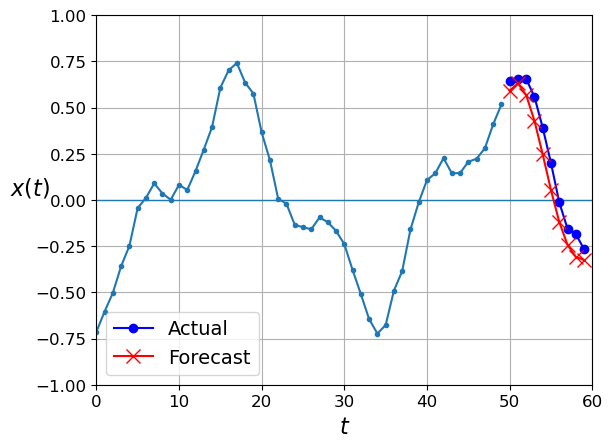

In [39]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### Deep RNN with Batch Norm 